# Capstone: Sentiment Analysis for Shopee
## Classification Modeling and Topic Modeling
__Grace Chia__

---

## Problem Statement

Shopee is a fast-growing e-commerce platform in Southeast Asia. In order to build an enjoyable online shopping experience, Shopee's product managers would first need to identify customer sentiment and understand users' pain points.

As such, the data science team has been tasked to classify the positive and negative reviews on Shopee Singapore's Google Play using Natural Language Processing (NLP). The model that achieves the highest accuracy and recall on the validation set will be selected for production. The team will be using topic modeling to identify the key pain points among dissatisfied customers. This will enable product managers to address their immediate needs.

## Executive Summary

The data science team web scraped 4,461 unique user reviews on Shopee's Google Play. Classical machine learning and deep learning NLP approaches were explored when building a sentiment classification model for Shopee reviews. The Voting Classifier was eventually selected as our production model as it achieved the highest accuracy and recall on the validation set. An ensemble of a TF-IDF Logistic Regression and a TF-IDF SVC, the Voting Classifier attained an accuracy of 0.904 and a recall of 0.87 on the validation data. When scored on the test set, the production model achieved 0.892 on accuracy and 0.87 on recall, outperforming the baseline accuracy of 0.61. We can thus conclude that the model generalises well on unseen data. This model serves as a good start for Shopee's product managers to classify sentiments and understand customers' pain points through Google Play reviews. The model was deployed to [Heroku](https://shopee-sentiment-analysis.herokuapp.com/).

The data science team has also identified 3 pain points among dissatisfied customers through topic modeling. These pain points include a poor payment experience, fraudulent sellers and items, and slow app performance. Addressing these pain points would not only promote an enjoyable shopping experience for customers, but would also differentiate Shopee from its competition.

Customers are most frustrated when they run into payment issues during checkout. The payment was either denied or the payment page simply took too long to load. Product managers will need to work closely with software engineers to enhance the stability and reliability of its payment gateway service. 

Several customers have dealt with fraudulent sellers on Shopee. Identifying and blocking fraudulent sellers at the early stages is the key to fraud prevention. This involves tracking a range of behavioural pattern among sellers and combing through their digital identity for any signs of suspicious behaviour. Shopee could also improve its buyers' protection scheme to regain consumers’ trust. 

Users have reported that the app hangs or crashes at the login and payment page. As such, developers will need to optimise its traffic scheduling platform's latency to accommodate high traffic during big sale events.

## Data Dictionary

An overview of the features in our dataset.

| Feature     	| Type 	| Description                                                       	|
|:-------------	|:------	|:-------------------------------------------------------------------	|
| content     	| obj  	| Raw text containing user reviews                                  	|
| content_stem 	| obj  	| Pre-processed text for modeling                                   	|
| score       	| int  	| No. of star ratings the user gave (1-5)                           	|
| target      	| int  	| Target variable <br>Postive sentiment: 0<br>Negative sentiment: 1 	|

## Model Evaluation: Summary

The table below provides an overview of the models' performance, sorted by accuracy and recall on the validation set in descending order.

|                                                             	| Accuracy on Training Set 	| Accuracy on Validation Set 	| Recall on Validation Set 	|
|:-------------------------------------------------------------	|:--------------------------:	|:----------------------------:	|:--------------------------:	|
| Voting Classifier (TF-IDF Logistic Regression & TF-IDF SVC) 	| 0.902                    	| 0.904                      	| 0.87                     	|
| TF-IDF & SVC                                                	| 0.901                    	| 0.899                      	| 0.87                     	|
| Count Vectorizer & Naïve Bayes                              	| 0.898                    	| 0.898                      	| 0.83                     	|
| Bidirectional LSTM                                          	| 0.916                    	| 0.896                      	| 0.82                     	|
| TF-IDF & Logistic Regression                                	| 0.906                    	| 0.892                      	| 0.81                     	|
| TF-IDF & Naïve Bayes                                        	| 0.904                    	| 0.882                      	| 0.79                     	|
| Count Vectorizer & SVC                                      	| 0.900                    	| 0.872                      	| 0.75                     	|
| Count Vectorizer & Logistic Regression                      	| 0.882                    	| 0.861                      	| 0.71                     	|

|                                                                               	| Accuracy on Test Set 	| Recall on Test Set 	|
|-------------------------------------------------------------------------------	|----------------------	|--------------------	|
| Production Model: Voting Classifier (TF-IDF Logistic Regression & TF-IDF SVC) 	| 0.892                	| 0.87               	|

## Contents:
- [Import Libraries](#Import-Libraries)
- [Load Data](#Load-Data)
- [Modeling](#Modeling)
    - [Classical Machine Learning](#Classical-Machine-Learning)
    - [Deep Learning](#Deep-Learning)
- [Model Evaluation: Summary Metrics](#Model-Evaluation:-Summary-Metrics)
- [Production Model's Most Predictive Words](#Production-Model's-Most-Predictive-Words)
- [Misclassified Reviews in Validation Set](#Misclassified-Reviews-in-Validation-Set)
- [Evaluate Production Model on Test Set](#Evaluate-Production-Model-on-Test-Set)
    - [Misclassified Reviews in Test Set](#Misclassified-Reviews-in-Test-Set)
- [Topic Modeling for Negative Sentiment](#Topic-Modeling-for-Negative-Sentiment)
    - [Pain Points and Recommendations](#Pain-Points-and-Recommendations)
- [Conclusion](#Conclusion)

## Import Libaries

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Libraries for classical machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Libraries for deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

# Libraries for topic modeling
from pprint import pprint
import gensim
import spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
import pyLDAvis.gensim

%matplotlib inline

## Load Data

Load in Shopee's Google Play reviews that we have collected, cleaned and pre-processed.

In [5]:
# Read the clean dataset
reviews = pd.read_csv('../data/clean_train.csv')

In [6]:
# View the first 5 rows of our dataset
reviews.head()

,content,content_stem,score,target
0,For god sake yr welcome gift T&C isnt stated c...,god sake yr welcom gift c isnt state clearli o...,2,1
1,Shopee has a wild variety of products however ...,wild varieti product howev buy certain stuff w...,3,1
2,Cheap and very fast...I love order here..,cheap fast love order,5,0
3,Overall no complains it's good,overal complain good,5,0
4,Reliable and cheap👍👍👍,reliabl cheap,5,0


In [7]:
# 3515 documents in our dataset
reviews.shape

(3478, 4)

In [8]:
# Check the data types
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3478 entries, 0 to 3477
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   content       3478 non-null   object
 1   content_stem  3478 non-null   object
 2   score         3478 non-null   int64 
 3   target        3478 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 108.8+ KB


In [9]:
# Establish our baseline score
reviews['target'].value_counts(normalize=True)

0    0.609833
1    0.390167
Name: target, dtype: float64

Given that the majority class is class 0, our **baseline score** is an accuracy of **0.61**. The baseline score will serve as a point of comparison when evaluating our models.

## Pre-Modeling

In [10]:
X = reviews['content_stem']
y = reviews['target']

In [11]:
# Perform train test split so that we can train, score and tune our models' hyperparameters 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
X_train.shape

(2782,)

In [13]:
X_val.shape

(696,)

In [14]:
y_train.value_counts(normalize=True)

0    0.609993
1    0.390007
Name: target, dtype: float64

In [15]:
y_val.value_counts(normalize=True)

0    0.609195
1    0.390805
Name: target, dtype: float64

In [31]:
# Use count vectorizer to check how many unique words there are
cvec = CountVectorizer(stop_words='english') 
cvec_df = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names_out())
cvec_df.shape

(2782, 2632)

There are 2632 unique words in our corpus.

In [32]:
# Write a function that takes in the actual y value and model predictions, 
# and prints out the confusion matrix and classification report
# Dataset: Validation or test set

def cmat(actual_y, predictions, dataset):
    
    # Create a classification report
    print('Classification report for', dataset)
    print(classification_report(actual_y, predictions))
    print('')
    
    # Create a confusion matrix
    cm = confusion_matrix(actual_y, predictions)
    cm_df = pd.DataFrame(cm, columns=['Predicted Positive Review','Predicted Negative Review'], index=['Actual Positive Review', 'Actual Negative Review'])
    print('Confusion matrix for', dataset)
    print(cm_df)

## Modeling

We will explore both classical machine learning and deep learning for sentiment analysis. The production model will be selected based on accuracy and recall on the validation set. 

## Classical Machine Learning

We will use the Bag of Words (BoW) representation to extract features from the text. This will be done through vectorization, specifically the CountVectorizer and TF-IDF Vectorizer. The CountVectorizer simply tokenizes and counts the word occurrences in our corpus. While on the other hand, TF-IDF tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power.  

After vectorizing, we will fit a Logistic Regression, Naive Bayes and Support Vector Machine on the training data and evaluate the models' performance on the validation set.

### Count Vectorizer & Logistic Regression

In [33]:
# Create a pipeline with Count Vectorizer and Logistic Regression
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), 
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_lr_params = {
    'cvec__max_features': [300], #100,200
    'cvec__min_df': [2,3], 
    'cvec__max_df': [.9,.95], 
#     'cvec__ngram_range':[(1,1),(1,2)],  
    'lr__penalty': ['l2'],
    'lr__C': [.01,.1]
}

# Instantiate GridSearchCV
gs_cvec_lr = GridSearchCV(pipe_cvec_lr, # Objects to optimise
                          param_grid = pipe_cvec_lr_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_lr.fit(X_train, y_train)

# Generate predictions on validation set
cvec_lr_pred = gs_cvec_lr.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_lr.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_lr.best_score_)
print('Training score:', gs_cvec_lr.score(X_train, y_train))
print('Validation score:', gs_cvec_lr.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_lr_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 300, 'cvec__min_df': 2, 'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV score:  0.8587362368169981
Training score: 0.8820992092020129
Validation score: 0.860632183908046

Classification report for validation set
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       424
           1       0.91      0.71      0.80       272

    accuracy                           0.86       696
   macro avg       0.87      0.83      0.85       696
weighted avg       0.87      0.86      0.86       696


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        405                         19
Actual Negative Review                         78                        194


### TF-IDF & Logistic Regression

In [34]:
# Create a pipeline with TF-IDF and Logistic Regression
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_tvec_lr_params = {
    'tvec__max_features': [300], #100,200
    'tvec__min_df': [2,3], #2,3 
    'tvec__max_df': [.9,.95], 
#     'tvec__ngram_range':[(1,1),(1,2)],  
    'lr__penalty': ['l2'],
    'lr__C': [.1, 1] #.1, .01
}

# Instantiate GridSearchCV
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, # Objects to optimise
                          param_grid = pipe_tvec_lr_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_lr.fit(X_train, y_train)

# Generate predictions on validation set
tvec_lr_pred = gs_tvec_lr.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_lr.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_lr.best_score_)
print('Training score:', gs_tvec_lr.score(X_train, y_train))
print('Validation score:', gs_tvec_lr.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_lr_pred, 'validation set')

Best parameters:  {'lr__C': 1, 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': 300, 'tvec__min_df': 2}
Best CV score:  0.8767050875428689
Training score: 0.905823148813803
Validation score: 0.8922413793103449

Classification report for validation set
              precision    recall  f1-score   support

           0       0.89      0.95      0.91       424
           1       0.91      0.81      0.85       272

    accuracy                           0.89       696
   macro avg       0.90      0.88      0.88       696
weighted avg       0.89      0.89      0.89       696


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        401                         23
Actual Negative Review                         52                        220


### Count Vectorizer & Naive Bayes

In [35]:
# Create a pipeline with Count Vectorizer and Naive Bayes
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_cvec_nb_params = {
    'cvec__max_features': [500], #200
    'cvec__min_df': [2,3],
    'cvec__max_df': [.9,.95], 
#     'cvec__ngram_range':[(1,1),(1,2)],  
}

# Instantiate GridSearchCV
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # Objects to optimise
                          param_grid = pipe_cvec_nb_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_nb.fit(X_train, y_train)

# Generate predictions on validation set
cvec_nb_pred = gs_cvec_nb.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_nb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_nb.best_score_)
print('Training score:', gs_cvec_nb.score(X_train, y_train))
print('Validation score:', gs_cvec_nb.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_nb_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 500, 'cvec__min_df': 2}
Best CV score:  0.8856914468425259
Training score: 0.8979151689432063
Validation score: 0.8979885057471264

Classification report for validation set
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       424
           1       0.90      0.83      0.86       272

    accuracy                           0.90       696
   macro avg       0.90      0.89      0.89       696
weighted avg       0.90      0.90      0.90       696


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        399                         25
Actual Negative Review                         46                        226


### TF-IDF & Naive Bayes

In [36]:
# Create a pipeline with TF-IDF and Naive Bayes
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_tvec_nb_params = {
    'tvec__max_features': [500], #200
    'tvec__min_df': [2,3], #
    'tvec__max_df': [.9,.95], 
#     'tvec__ngram_range':[(1,1),(1,2)],  
}

# Instantiate GridSearchCV
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, # Objects to optimise
                          param_grid = pipe_tvec_nb_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_nb.fit(X_train, y_train)

# Generate predictions on validation set
tvec_nb_pred = gs_tvec_nb.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_nb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_nb.best_score_)
print('Training score:', gs_tvec_nb.score(X_train, y_train))
print('Validation score:', gs_tvec_nb.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_nb_pred, 'validation set')

Best parameters:  {'tvec__max_df': 0.9, 'tvec__max_features': 500, 'tvec__min_df': 2}
Best CV score:  0.8838941749825946
Training score: 0.9043853342918764
Validation score: 0.882183908045977

Classification report for validation set
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       424
           1       0.90      0.79      0.84       272

    accuracy                           0.88       696
   macro avg       0.89      0.87      0.87       696
weighted avg       0.88      0.88      0.88       696


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        400                         24
Actual Negative Review                         58                        214


### Count Vectorizer & SVC

In [37]:
# Create a pipeline with Count Vectorizer and SVC
pipe_cvec_svc = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('svc', SVC(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_svc_params = {
    'cvec__max_features': [300], #200,500
    'cvec__min_df': [2,3], 
    'cvec__max_df': [.9,.95], 
#     'cvec__ngram_range':[(1,1),(1,2)],  
    'svc__kernel': ['linear'], #'poly', 'rbf'
#     'svc__degree': [3],
    'svc__C': [.1]
}

# Instantiate GridSearchCV
gs_cvec_svc = GridSearchCV(pipe_cvec_svc, # Objects to optimise
                          param_grid = pipe_cvec_svc_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_svc.fit(X_train, y_train)

# Generate predictions on validation set
cvec_svc_pred = gs_cvec_svc.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_svc.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_svc.best_score_)
print('Training score:', gs_cvec_svc.score(X_train, y_train))
print('Validation score:', gs_cvec_svc.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_svc_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 300, 'cvec__min_df': 2, 'svc__C': 0.1, 'svc__kernel': 'linear'}
Best CV score:  0.8734689667620742
Training score: 0.9000718907260963
Validation score: 0.8721264367816092

Classification report for validation set
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       424
           1       0.91      0.75      0.82       272

    accuracy                           0.87       696
   macro avg       0.88      0.85      0.86       696
weighted avg       0.88      0.87      0.87       696


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        403                         21
Actual Negative Review                         68                        204


### TF-IDF & SVC

In [38]:
# Create a pipeline with TF-IDF Vectorizer and SVC
pipe_tvec_svc = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('svc', SVC(probability=True, random_state=42)) 
])

# Search over the following values of hyperparameters:
pipe_tvec_svc_params = {
    'tvec__max_features': [800], #200,500
    'tvec__min_df': [2,3], 
    'tvec__max_df': [.9,.95], 
#     'tvec__ngram_range':[(1,1),(1,2)],  
    'svc__kernel': ['linear'], #'poly', 'rbf'
#     'svc__degree': [3],
    'svc__C': [.1] # .01
}

# Instantiate GridSearchCV
gs_tvec_svc = GridSearchCV(pipe_tvec_svc, # Objects to optimise
                          param_grid = pipe_tvec_svc_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_svc.fit(X_train, y_train)

# Generate predictions on validation set
tvec_svc_pred = gs_tvec_svc.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_svc.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_svc.best_score_)
print('Training score:', gs_tvec_svc.score(X_train, y_train))
print('Validation score:', gs_tvec_svc.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_svc_pred, 'validation set')

Best parameters:  {'svc__C': 0.1, 'svc__kernel': 'linear', 'tvec__max_df': 0.9, 'tvec__max_features': 800, 'tvec__min_df': 3}
Best CV score:  0.8810177664320158
Training score: 0.9011502516175414
Validation score: 0.8994252873563219

Classification report for validation set
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       424
           1       0.87      0.87      0.87       272

    accuracy                           0.90       696
   macro avg       0.89      0.89      0.89       696
weighted avg       0.90      0.90      0.90       696


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        389                         35
Actual Negative Review                         35                        237


### Voting Classifier

Given that the Logistic Regression and SVC are rather diverse algorithms, we will use ensemble learning in an attempt to improve our model's accuracy and recall. We will use a Voting Classifier where the winning class will be determined by soft voting. As the SVC returned a better recall rate than the Logistic Regression, we will give a higher voting weight to the SVC than the Logistic Regression.

In [39]:
# Instantiate the Voting Classifier with TF-IDF Logistic Regression and SVC
voting_clf = VotingClassifier(
    estimators=[('tvec_lr', gs_tvec_lr),
                ('tvec_svc', gs_tvec_svc)], 
    voting='soft', 
    weights=[1,2]
)

# Fit model on to training data
voting_clf.fit(X_train, y_train)

# Generate predictions on validation set
voting_pred = voting_clf.predict(X_val)

# Print accuracy scores
print('Training score:', voting_clf.score(X_train, y_train))
print('Validation score:', voting_clf.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, voting_pred, 'validation set')

Training score: 0.9022286125089863
Validation score: 0.9037356321839081

Classification report for validation set
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       424
           1       0.88      0.87      0.88       272

    accuracy                           0.90       696
   macro avg       0.90      0.90      0.90       696
weighted avg       0.90      0.90      0.90       696


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        393                         31
Actual Negative Review                         36                        236


The ensemble reduces the model's bias and returns a better accuracy score than the best of the base estimators.

## Deep Learning

LSTM is an extension of RNN and are very effective for sequential data like texts because they can relate to the sentence's context very well. Using corpus embedding from our dataset had in fact outperformed models that were built using pre-trained word embeddings like Word2vec and GloVe. This is probably due to domain specific nature of our dataset. Given the social media context and misspellings in our corpus, it is possible that there were no corresponding vectors from the pre-trained word embeddings. Hence, we will be using our corpus embedding to build a deep network.

In [40]:
# Extract the X and y values from the train and validation set
X_train_list = X_train.values
X_val_list = X_val.values

y_train_list = y_train.values
y_val_list = y_val.values

In [41]:
max_words = 1000 # Note: Model tends to overfit when max_words is set to 2000-3000 words

# Tokenize the data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(X_train_list))

# Convert the text to sequences
X_train_list = tokenizer.texts_to_sequences(X_train_list)
X_val_list = tokenizer.texts_to_sequences(X_val_list)

In [42]:
vocab_size = len(tokenizer.word_index)+1
print('Vocabulary size:', vocab_size)

Vocabulary size: 2756


Add padding to ensure that all the sequences have the same shape. As the average length of a negative review is 15 words and a positive review is 7 words, we will set a max length of 20.

In [43]:
max_length = 20 

X_train_padded = pad_sequences(X_train_list, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_list, maxlen=max_length, padding='post')

Next, we will create the network topology. The training data is fed to a three-layered neural network. The first layer is a Bidirectional LSTM with 8 nodes. The second layer is a dense layer with 8 nodes and the output layer with just one node.

In [44]:
# Instantiate model
model = Sequential()

# Add embedding layer, embed_dim:8
model.add(Embedding(vocab_size, 8, input_length=max_length)) 

# SpatialDropout1D performs variational dropout
model.add(SpatialDropout1D(0.2))

# Add LSTM
model.add(Bidirectional(LSTM(8, return_sequences=True, dropout=0.5, recurrent_dropout=0))) 

# Add a dense layer
model.add(Dense(8, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 8)             22048     
                                                                 
 spatial_dropout1d (SpatialD  (None, 20, 8)            0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 20, 16)           1088      
 l)                                                              
                                                                 
 dense (Dense)               (None, 20, 8)             136       
                                                                 
 dense_1 (Dense)             (None, 20, 1)             9         
                                                                 
Total params: 23,281
Trainable params: 23,281
Non-traina

We have created callbacks to save the models and weights. Note that we have intentionally commented out the following cells to avoid re-running the cells which will generate a different set of models and weights.

In [46]:
# Callback to save the models and weights

# outputFolder = '../output'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)
# filepath = outputFolder+"/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"

# checkpoint_callback = ModelCheckpoint(
#     filepath, monitor='val_accuracy', verbose=1,
#     save_best_only=False, save_weights_only=False,
#     save_frequency=1)

In [47]:
# %%time
# Fit the model and store it in the history object
# history = model.fit(X_train_padded, y_train_list, epochs=10, batch_size=64, validation_data=(X_val_padded, y_val_list), callbacks=[checkpoint_callback])

<img src="../images/lstm_fit_output.png" width="1200" align="left">

In [48]:
# Plot the training and validation loss by epoch

# plt.figure(figsize=(10,8))
# epochs = range(1,11)
# plt.plot(epochs, history.history['loss'], label='Training loss')
# plt.plot(epochs, history.history['val_loss'], label='Validation loss')
# plt.title('Training and Validation Loss by Epoch', size=15, weight='bold')
# plt.xlabel('Epochs', size=12)
# plt.ylabel('Loss', size=12)
# plt.xticks(np.arange(1,11,1))
# plt.legend();

<img src="../images/loss_by_epoch.png" width="600" align="left">

In [49]:
# Plot the training and validation accuracy by epoch

# plt.figure(figsize=(10,8))
# epochs = range(1,11)
# plt.plot(epochs, history.history['accuracy'], label='Training accuracy')
# plt.plot(epochs, history.history['val_accuracy'], label='Validation accuracy')
# plt.title('Training and Validation Accuracy by Epoch', size=15, weight='bold')
# plt.xlabel('Epochs', size=12)
# plt.ylabel('Accuracy', size=12)
# plt.xticks(np.arange(1,11,1))
# plt.legend();

<img src="../images/accuracy_by_epoch.png" width="600" align="left">

Given that validation loss stagnants after the 5th epoch while accuracy peaks at the 5th epoch, we will use the weights from model-05.


### Loading a check-pointed model

In [55]:
# Load weights
model.load_weights('../output/model-05-0.90.hdf5')

In [59]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
# Generate predictions on validation set
class_preds = (model.predict(X_val_padded) > 0.5).astype(int)

22/22 [==============================] - 1s 2ms/step


In [61]:
val_preds = []

# Loop through the class prediction list and append the predictions to val_preds
for i in class_preds:
    val_preds.append(i[0][0])

# Convert val_preds to a series
val_preds = pd.Series(val_preds)

In [75]:
# Accuracy scores
print('Accuracy score on training set: ', model.evaluate(X_train_padded, y_train_list, verbose=0)[1])
print('Accuracy score on validation set: ', model.evaluate(X_val_padded, y_val_list, verbose=0)[1])
print('')

# Print classification report and confusion matrix for validation set
cmat(y_val, val_preds, 'validation set')

ValueError: in user code:

    File "d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1790, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\losses.py", line 2156, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py", line 5707, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 20, 1) vs (None,)).


LSTM did not outperform our BoW model, the Voting Classifier, in accuracy or recall. This may be due to the fact that our dataset is rather small with an average of 7-15 words per review.

## Model Evaluation: Summary Metrics

The table below provides an overview of the models' performance, sorted by accuracy and recall on the validation set in descending order.

|                                                             	| Accuracy on Training Set 	| Accuracy on Validation Set 	| Recall on Validation Set 	|
|:-------------------------------------------------------------	|:--------------------------:	|:----------------------------:	|:--------------------------:	|
| Voting Classifier (TF-IDF Logistic Regression & TF-IDF SVC) 	| 0.902                    	| 0.904                      	| 0.87                     	|
| TF-IDF & SVC                                                	| 0.901                    	| 0.899                      	| 0.87                     	|
| Count Vectorizer & Naïve Bayes                              	| 0.898                    	| 0.898                      	| 0.83                     	|
| Bidirectional LSTM                                          	| 0.916                    	| 0.896                      	| 0.82                     	|
| TF-IDF & Logistic Regression                                	| 0.906                    	| 0.892                      	| 0.81                     	|
| TF-IDF & Naïve Bayes                                        	| 0.904                    	| 0.882                      	| 0.79                     	|
| Count Vectorizer & SVC                                      	| 0.900                    	| 0.872                      	| 0.75                     	|
| Count Vectorizer & Logistic Regression                      	| 0.882                    	| 0.861                      	| 0.71                     	|

The Voting Classifier was selected as our production model as it achieved the highest accuracy and recall on the validation set. An ensemble of a logistic regression and SVC, the Voting Classifier attained an accuracy of 0.904 on the validation data and a recall of 0.87. Given that the model is able to correctly predict 87% of the actual negative reviews on Google Play, Shopee's product managers will now be able to identify negative reviews and understand the pain points among dissatisfied customers.  

As the base estimators (Logistic Regression and SVC) of our Voting Classifier are rather diverse, the ensemble results in a better accuracy score than the best of the base estimators. The ensemble aggregates the predictions of the base estimators and helps to cover for the weaknesses of the individual models, which in turn reduces the production model's bias.

The model was deployed to [Heroku](https://shopee-sentiment-analysis.herokuapp.com/).

## Production Model's Most Predictive Words

Now, let's look at the most predictive words from the Logistic Regression and SVC to understand how our Voting Classifier classifies positive and negative sentiment.

### Logistic Regression

In [77]:
# Save the words obtained from TF-IDF vectorizer in a dataframe
lr_coef = pd.DataFrame(gs_tvec_lr.best_estimator_.named_steps['tvec'].get_feature_names_out(), columns=['word'])

In [78]:
# Use np.exp() to exponentiate the coefficients
lr_coef['exp_coef'] = np.exp(gs_tvec_lr.best_estimator_.named_steps['lr'].coef_[0])

In [79]:
# Top words related to positive sentiment (class 0)
pos_sent_lr = lr_coef.sort_values(by='exp_coef').head(10)

# Top words related to negative sentiment (class 1)
neg_sent_lr = lr_coef.sort_values(by='exp_coef').tail(10)

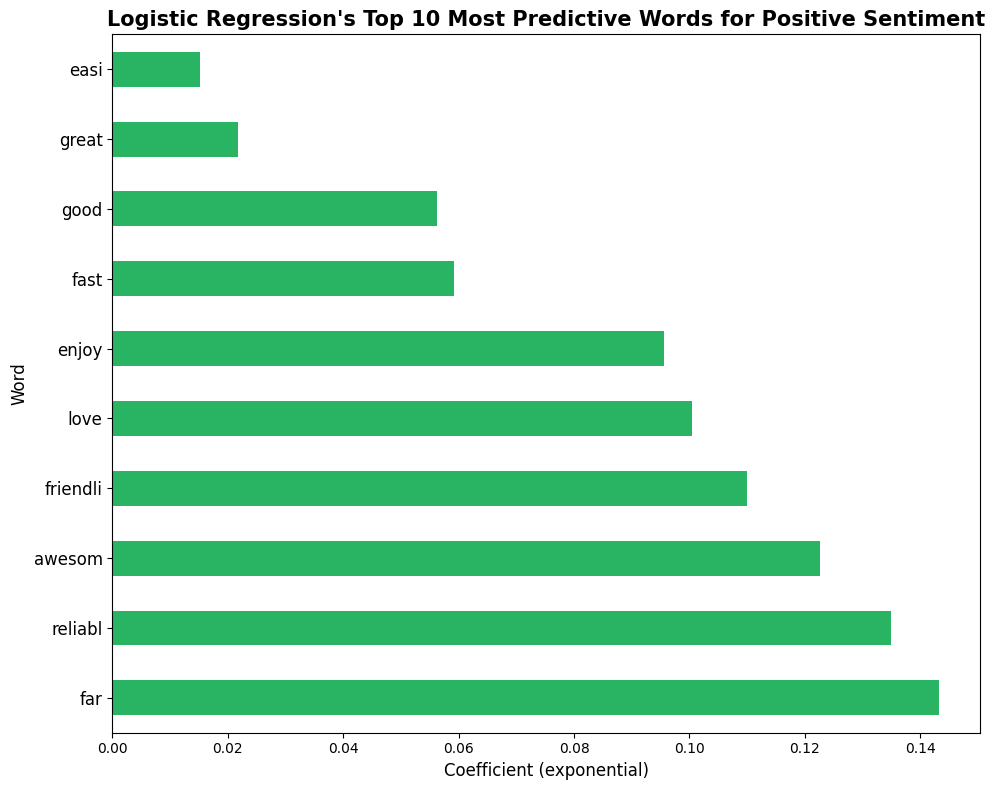

In [80]:
pos_sent_lr.sort_values('exp_coef', ascending=False).plot(x='word', y='exp_coef', kind='barh', figsize=(10,8), legend=None, color='#28B463')
plt.title("Logistic Regression's Top 10 Most Predictive Words for Positive Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient (exponential)", size=12)
plt.tight_layout();

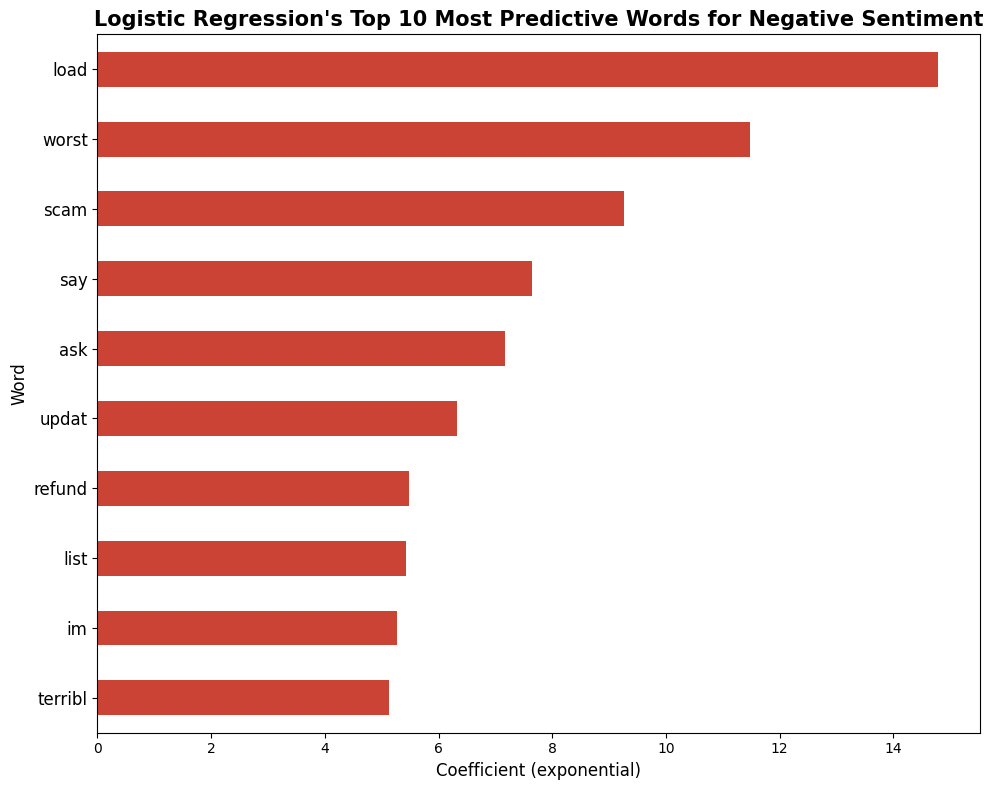

In [82]:
neg_sent_lr.plot(x='word', y='exp_coef', kind='barh', figsize=(10,8), legend=None, color='#CB4335')
plt.title("Logistic Regression's Top 10 Most Predictive Words for Negative Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient (exponential)", size=12)
plt.tight_layout();

Words like 'easi', 'great', 'good' are the most predictive words associated with positive sentiment. 'Easi' probably refers to Shopee's easy to use shopping platform. On the other hand, 'load', 'worst' and 'scam' are most closely associated to negative sentiment. 'Load' probably relates to the app taking a long time to load while 'scam' may indicate that several customers have encountered seller scams on Shopee. As the occurence of the word 'load' increases by 1, the likelihood of the review being negative, increases by more than 14 times.

### SVC

In [84]:
# Save the words obtained from TF-IDF vectorizer in a dataframe
svc_coef = pd.DataFrame(gs_tvec_svc.best_estimator_.named_steps['tvec'].get_feature_names_out(), columns=['word'])

In [85]:
# Coefficients
svc_coef['coef'] = gs_tvec_svc.best_estimator_.named_steps['svc'].coef_.toarray()[0]

In [86]:
# Top words related to positive sentiment (class 0)
pos_sent_svc = svc_coef.sort_values(by='coef').head(10)

# Top words related to negative sentiment (class 1)
neg_sent_svc = svc_coef.sort_values(by='coef').tail(10)

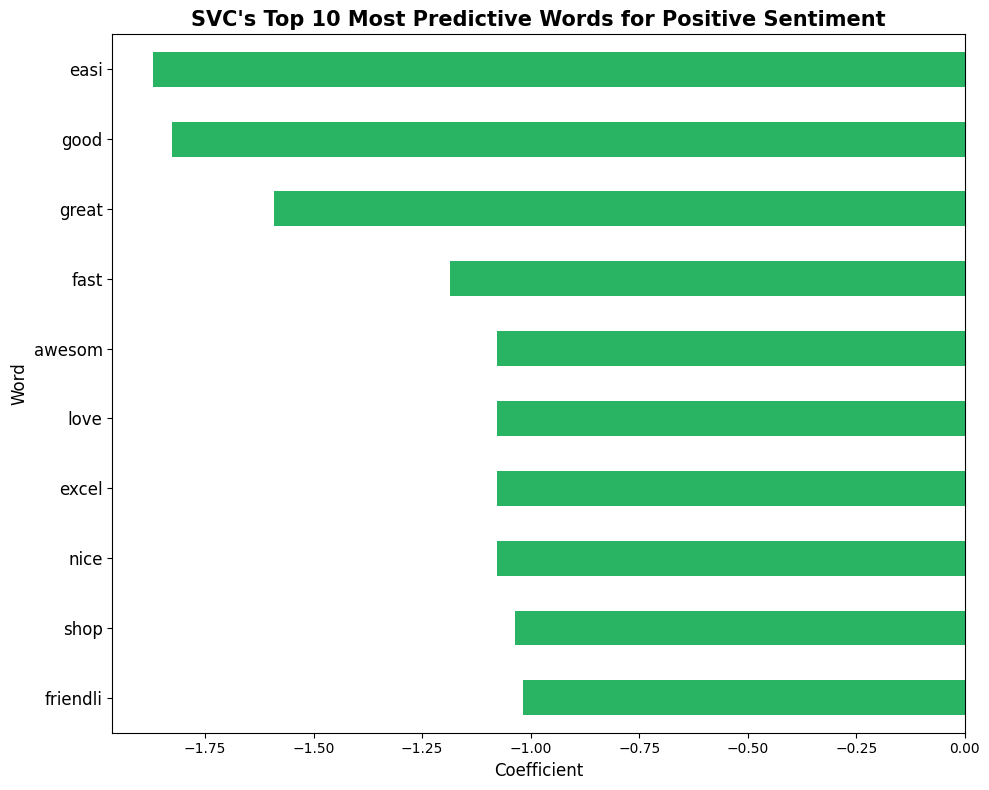

In [87]:
pos_sent_svc.sort_values('coef', ascending=False).plot(x='word', y='coef', kind='barh', figsize=(10,8), legend=None, color='#28B463')
plt.title("SVC's Top 10 Most Predictive Words for Positive Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient", size=12)
plt.tight_layout();

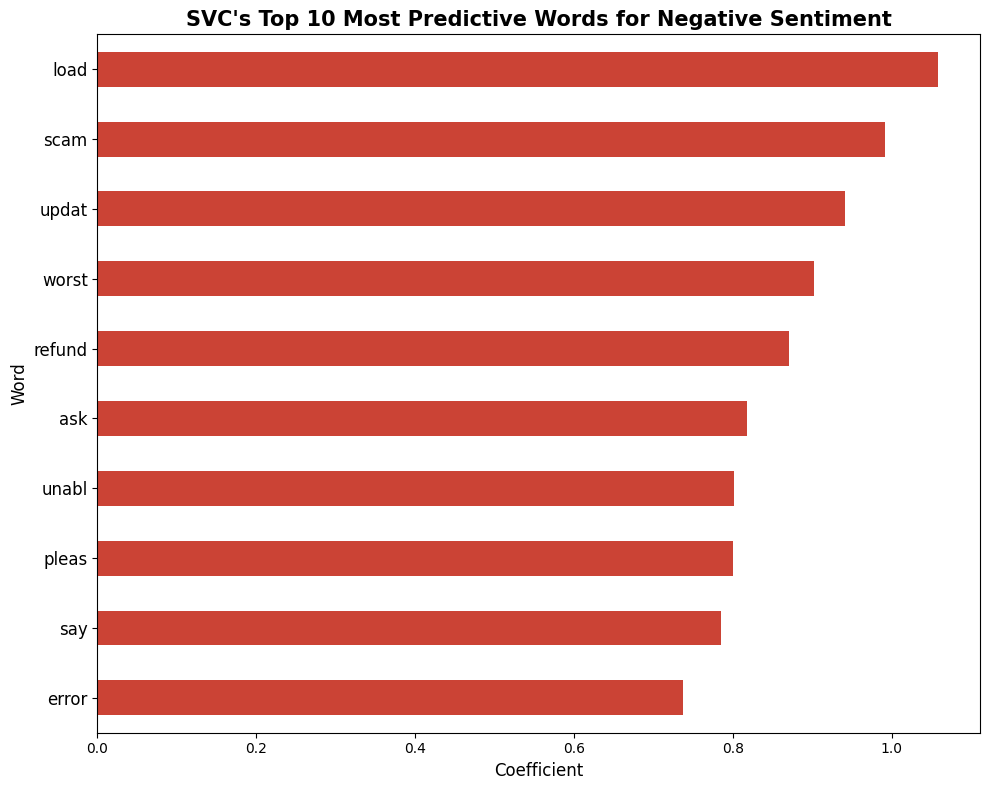

In [88]:
neg_sent_svc.plot(x='word', y='coef', kind='barh', figsize=(10,8), legend=None, color='#CB4335')
plt.title("SVC's Top 10 Most Predictive Words for Negative Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient", size=12)
plt.tight_layout();

Given that the SVC is non-parametric, we are unable to directly interpret the model's coefficient. Nonetheless, we can tell that there are certain words that are closely related to the positive or negative sentiment in our corpus. Similar to the logistic regression, the SVC indicates that the words 'easi', 'good' and 'great' are related to positive sentiments. On the other hand, words like 'load', 'scam' and 'updat' are closely associated to negative reviews.

## Misclassified Reviews on Validation Set

Let's have a look at the misclassified reviews to understand the limitations in our production model.

In [89]:
# Create a dataframe for only the validation data
val_df = reviews.loc[y_val.index, :] 

# Insert a column for predictions
val_df['pred'] = voting_pred

In [90]:
# Create a column to indicate if the review was correctly predicted
val_df['correctly_classified'] = (val_df['pred'] == val_df['target'])

In [91]:
# 67 misclassified reviews
val_df[val_df['correctly_classified']==0].shape

(67, 6)

In [93]:
# Display the full width so that we can read the misclassified reviews
pd.set_option('display.max_colwidth', None)

# View the False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
val_df[(val_df['target']==0) & (val_df['pred']==1)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
1497,The app always crashes when log in it keep saying loading now cannot get into account Update : works now,alway crash log keep say load cannot get account updat work,4,0,1
2408,more promo code,promo code,4,0,1
2467,Shopee has become one of my most frequented app...my wallet is crying 😂,becom one frequent wallet cri,5,0,1
1018,Very laggy. Takes 3 to 5 secs for each page to load,laggi take sec page load,4,0,1
2208,No comment,comment,5,0,1
1592,Shock!,shock,4,0,1
3327,"I like how most of my purchases are fulfilled and refunds are done on time and everything is tracked perfectly. Also, bring back BlackPink as the face of Shopee instead of discount Ronaldo.",like purchas fulfil refund done time everyth track perfectli also bring back blackpink face instead discount ronaldo,5,0,1
2086,Can be trusted.,trust,5,0,1
1230,it's long wait to open the apps.,long wait open app,4,0,1
3384,Friends unable to use my referral code,friend unabl use referr code,4,0,1


In [94]:
# View the False Negatives - Model incorrectly predicts these as positive sentiment when they are actually negative sentiment
val_df[(val_df['target']==1) & (val_df['pred']==0)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
2865,"Too much clutter in the interface, shopping experience could and should be much more streamlined",much clutter interfac shop experi could much streamlin,3,1,0
1855,"One of the seller increased the product(mask) price and choose not to ship out my item, it's so unethical. However shopee customer service cant do anything to it.",one increas product mask price choos ship uneth howev custom servic cant anyth,1,1,0
2381,good to buy,good buy,3,1,0
2890,"Like Trezo photo upload option is limited. Carousell has a wider range of options and allows photo upload from dropbox, which makes it a much better and convenient app for sellers.",like trezo photo upload option limit carousel wider rang option allow photo upload dropbox make much better conveni,2,1,0
2414,"App getting slower , products getting more expensive",get slower product get expens,3,1,0
1331,"Shopee is a biased platform whom sides sellers more than buyers. These words came from Shopee CSR themselves that Sellers are able to delete ratings from buyers without consent from buyers. Hence, it is impossible to know if sellers on the platform are reputable or not even based on the ratings as dishonest sellers are able to remove the 'bad' ratings from buyers, to 'look good'. Not recommending this unfair platform to any others!",bias platform side buyer word came csr abl delet rate buyer without consent buyer henc imposs know platform reput even base rate dishonest abl remov rate buyer look good recommend unfair platform other,1,1,0
942,Bad unfriendly user interface.,unfriendli user interfac,1,1,0
1346,It's says 'free shipping' and 'COD' but some stores aren't free shipping and cash on delivery. 😕,say free ship cod store free ship cash deliveri,3,1,0
2521,"Although tools for selling are advanced, however it can't really generate sales. But you can Really get good deals often from coupon codes.",although tool sell advanc howev realli gener sale realli get good deal often coupon code,2,1,0
3029,"Many items, reasonable pricing but during the 11.11 sale, i encountered cancellation of my orders by the seller after the orders were accepted and payment made, giving reasons like ""undeliverable area"". HDB in Singapore undeliverable? Unbelievable! Another reason is out of stock, but the order was accepted in the first instance! Overall still a good e-commerce site despite these shortcomings. Hence, the 3 stars rather than 5.",mani reason price sale encount cancel order order accept payment made give reason like undeliver area hdb singapor undeliver unbeliev anoth reason stock order accept first instanc overal still good e commerc site despit shortcom henc star rather,3,1,0


Now, that we have looked through the false positives and false negatives. We will identify the top most frequently occuring words to explain the misclassifications.

In [98]:
# Plot a barplot of the top 20 most frequently occuring words in misclassified reviews

def barplot_tvec(df, pred, title, color):
    words_series = df[(df['correctly_classified']==0) & (df['pred']==pred)]['content_stem']
    
    # Instantiate TF-IDF Vectorizer 
    tvec = TfidfVectorizer(stop_words='english')
    
    # Save the tokens in a dataframe
    tvec_df = pd.DataFrame(tvec.fit_transform(words_series).todense(), columns=tvec.get_feature_names_out())
    sum_words = tvec_df.sum(axis=0) # Sum up the no. of occurences for each word
    top_words = sum_words.sort_values(ascending=False).head(10)
    top_words.sort_values(ascending=True).plot(kind='barh', figsize=(10,8), color=color)
    
    # Chart aesthetics
    plt.title(title, size=15, weight='bold')
    plt.xlabel('Count', size=12)
    plt.xlim(0,5)
    plt.yticks(size=12)
    plt.tight_layout()

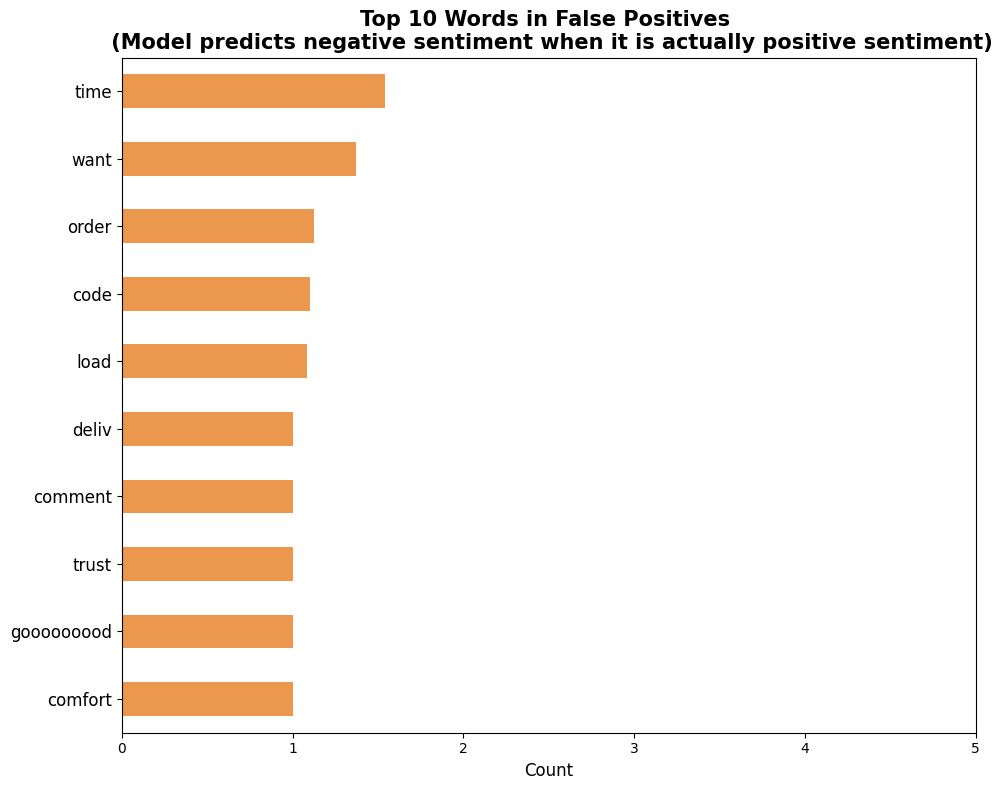

In [99]:
# Top words seen in False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
barplot_tvec(df=val_df,
             pred=1, 
             title="Top 10 Words in False Positives \n (Model predicts negative sentiment when it is actually positive sentiment)", 
             color='#EB984E')

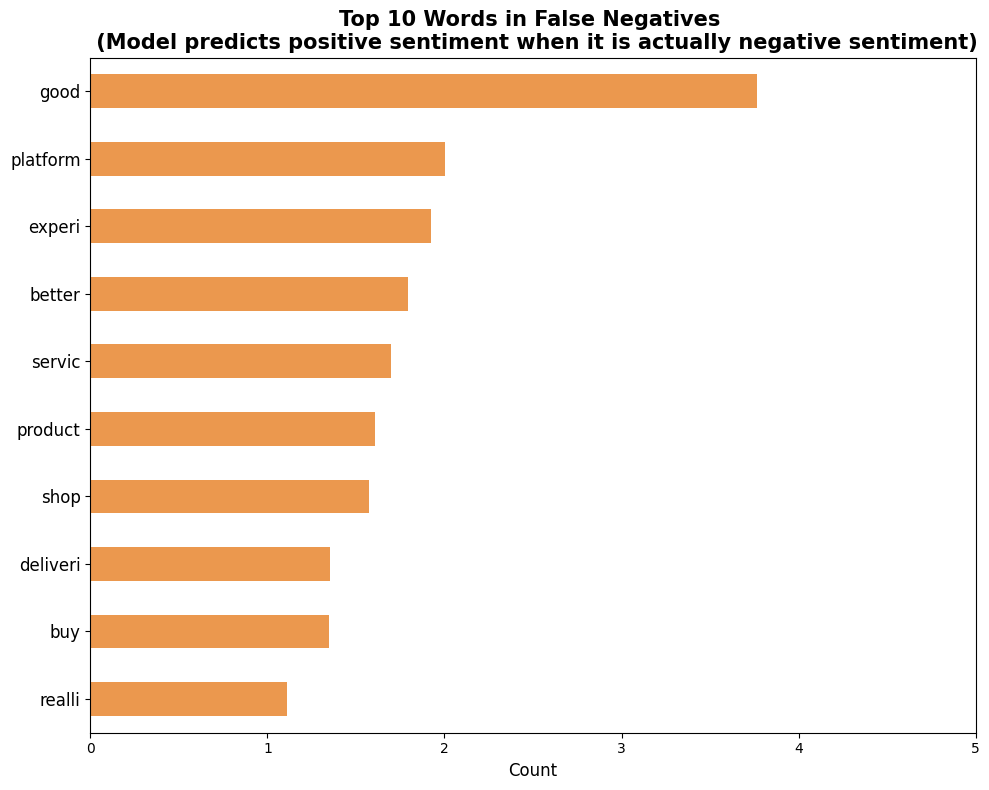

In [100]:
# Top words seen in False Negatives - Model incorrectly predicts these as postive sentiment when they are actually negative sentiment
barplot_tvec(df=val_df,
             pred=0, 
             title="Top 10 Words in False Negatives \n (Model predicts positive sentiment when it is actually negative sentiment)", 
             color='#EB984E')

As observed in the previous section, the word 'good' is a highly predictive word that is closely associated to positive sentiments. Given that the word 'good' appears most frequently in false negatives, the model will incorrectly predict these reviews as having a positive sentiment.

In [101]:
# False Negatives
fn = val_df[(val_df['correctly_classified']==0) & (val_df['pred']==0)][['content','content_stem','score']]

In [102]:
# Count the number of times the word 'good' appears in the review
fn['count_good'] = fn['content_stem'].str.count('good')

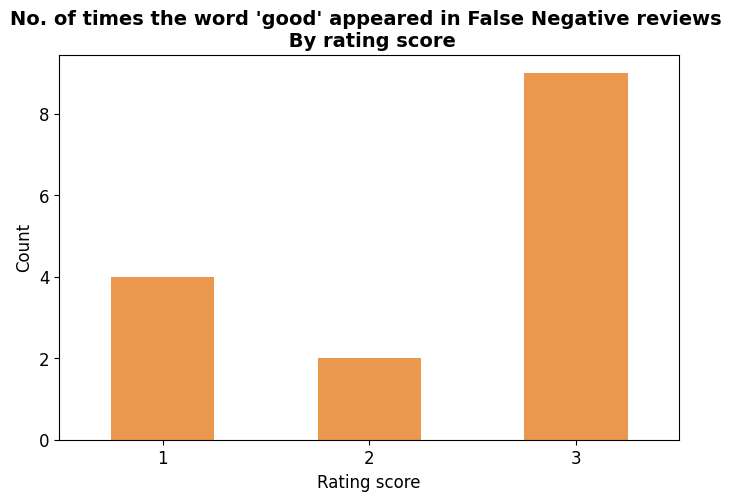

In [103]:
plt.figure(figsize=(8,5))

# Group False Negative reviews by their ratings and sum up the no. of times the word 'good' was seen
fn.groupby('score')['count_good'].sum().plot(kind='bar', color='#EB984E')

plt.title("No. of times the word 'good' appeared in False Negative reviews \n By rating score", size=14, weight='bold')
plt.ylabel("Count", size=12)
plt.yticks(size=12)
plt.xlabel("Rating score", size=12)
plt.xticks(size=12, rotation=0);

We observe that there are quite a few users who wrote reviews with the word 'good' in them, yet gave the app a rating of 3. Since the model has been trained to believe that the word 'good' belongs to a positive sentiment, the model has thus predicted these to be positive reviews. Hence, misclassifications happen as a result of fence-sitters writing reviews that have positive connotation.

In [105]:
pd.set_option('display.max_colwidth', None)

# View only the False Negatives that has the words 'good' in it
fn[fn['count_good']>0][['content','score']]

,content,score
2381,good to buy,3
1331,"Shopee is a biased platform whom sides sellers more than buyers. These words came from Shopee CSR themselves that Sellers are able to delete ratings from buyers without consent from buyers. Hence, it is impossible to know if sellers on the platform are reputable or not even based on the ratings as dishonest sellers are able to remove the 'bad' ratings from buyers, to 'look good'. Not recommending this unfair platform to any others!",1
2521,"Although tools for selling are advanced, however it can't really generate sales. But you can Really get good deals often from coupon codes.",2
3029,"Many items, reasonable pricing but during the 11.11 sale, i encountered cancellation of my orders by the seller after the orders were accepted and payment made, giving reasons like ""undeliverable area"". HDB in Singapore undeliverable? Unbelievable! Another reason is out of stock, but the order was accepted in the first instance! Overall still a good e-commerce site despite these shortcomings. Hence, the 3 stars rather than 5.",3
2444,The return policy not good. Use Lazada better.,1
3330,Application is good bit I don't like the shopee agreement and policy. When I want to return the product shoppe is giving credit only to the seller and they are not considering the customer request. I hate this. So for the costly product I prefer other online portal.,3
3074,Sellers can easily cancel your orders even after assuring you that your orders can be shipped. Be careful of items that have prices that are too good to be true. Can't even leave feedback to bad sellers. Won't be buying from shopee again. Stick to lazada or qoo10 better.,1
1293,Good,3
2171,some reviews were censored. mostly faked review. others then that the price is good especially low delivery costs. buying no brand item pls be cautious.,2
145,good can be improved,3


## Evaluate Production Model on Test Set

Finally, we will evaluate our model's performance on the test set.

In [106]:
# Read test set into a dataframe
test = pd.read_csv('../data/clean_test.csv')

In [107]:
# There are 870 documents in our test set
test.shape

(870, 4)

In [108]:
# The class representation in our test set looks similar to our training set as we used stratify
test['target'].value_counts(normalize=True)

0    0.609195
1    0.390805
Name: target, dtype: float64

In [109]:
# Establish our X and y variables
X_test = test['content_stem']
y_test = test['target']

In [110]:
# Generate predictions on test set
test_pred = voting_clf.predict(X_test)

In [111]:
print('Evaluation metrics for test set')
print('')
print('Accuracy score: ', accuracy_score(y_test, test_pred))
print('')

# Print classification report and confusion matrix
cmat(y_test, test_pred, 'test set')

Evaluation metrics for test set

Accuracy score:  0.8919540229885058

Classification report for test set
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       530
           1       0.86      0.87      0.86       340

    accuracy                           0.89       870
   macro avg       0.89      0.89      0.89       870
weighted avg       0.89      0.89      0.89       870


Confusion matrix for test set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        480                         50
Actual Negative Review                         44                        296


Given that our production model achieves 0.892 on accuracy and 0.87 on recall, we can conclude that the model generalises well on unseen data.

### Misclassified Reviews in the Test Set

Let us have a look at the misclassifications in our test set.

In [112]:
# Generate predictions on the test set
test['pred'] = voting_clf.predict(X_test)

In [113]:
# Create a column to indicate if the review was correctly predicted
test['correctly_classified'] = (test['pred'] == test['target'])

In [114]:
# View the False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
test[(test['target']==0) & (test['pred']==1)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
13,"You have great sellers, and you have great exposure so there's more choices for consumers, but you need to work on developing the app further, the app experience is still quite buggy, loading from page to page usually crash the app, otherwise I would gladly give a 5 star rating, but you are new, so work on it yeah, I use shopee all the time so I'm rooting for ya!",great great exposur choic consum need work develop experi still quit buggi load page page usual crash otherwis would gladli give star rate new work yeah use time root ya,4,0,1
20,Moving sales & Ease for seller to transfer payment. Recent J&T sega shopee should have kept sellers promptly updated. The category listing team is overdue for an improvement. If incorrect they should send the suggested reco instead of wasting time on the to & fro correction.,move sale eas transfer payment recent j sega kept promptli updat categori list team overdu improv incorrect send suggest reco instead wast time fro correct,4,0,1
32,Some bugs on certain pages e.g. adding to cart sometimes makes the app hang. Otherwise one of the best e-shopping app for SG.,bug certain page e g ad cart sometim make hang otherwis one best e shop sg,4,0,1
36,"Shoppee is easy to use, however recently I saw my orders under (to ship) checked with seller, she said shipped, however no update on the movement.. this seller was not very responsive to my message, n I eventually cancelled the order.. then she told me shipped ..",easi use howev recent saw order ship check said ship howev updat movement respons messag n eventu cancel order told ship,4,0,1
79,Not too bad. Pls make search easier as there are many products,pl make search easier mani product,4,0,1
112,Seamless ordering,seamless order,5,0,1
113,"Overall are good, but i cannot access the bank card and account, it keep showing errors, hope that customer service can take noted.",overal good cannot access bank card account keep show error hope custom servic take note,4,0,1
118,Will buy again,buy,4,0,1
127,Okay,okay,4,0,1
137,Trusty worthy and once item recevied then only payment is release to Seller.,trusti worthi recevi payment releas,5,0,1


In [115]:
# View the False Negatives - Model incorrectly predicts these as positive sentiment when they are actually negative sentiment
test[(test['target']==1) & (test['pred']==0)][['content','content_stem','score','target','pred']]

,content,content_stem,score,target,pred
0,Just ok,ok,3,1,0
10,"Your shopee sg app is very bad. Worse than Lazada. Your category placing is also very bad. Not easy to scroll. What you advertised in the front scroll, is nowhere to find. Need to improve. I installed few times but very disappointed. Not friendly use at all.",sg wors lazada categori place also easi scroll advertis front scroll nowher find need improv instal time disappoint friendli use,1,1,0
46,"Cos i've received some unnecessary users & i believe these features are necessary esp for online shopping. Without these, it's a turn off",co receiv unnecessari user believ featur necessari esp onlin shop without turn,3,1,0
52,"I enjoyed using the app. However, I was banned out of nowhere and they provided no reason for my ban. Hoping I could get my account back cus I made orders before the ban.",enjoy use howev ban nowher provid reason ban hope could get account back cu made order ban,1,1,0
85,Happy using it,happi use,3,1,0
155,I bought stuff in shopee then i Dont get my stuff....,bought stuff dont get stuff,1,1,0
173,In general items are slightly cheaper than other online shops. But its Customer service are not that responsive. Emailed twice but no response.,gener slightli cheaper onlin shop custom servic respons email twice respons,3,1,0
174,Great job,great job,3,1,0
176,"Neat and user friendly interface. However, page keeps hanging after several scrolls.",neat user friendli interfac howev page keep hang sever scroll,3,1,0
202,Not a friendly platform for sellers. Uninstalling due to poor choices of category for sellers. TOTALLY Not recommended.,friendli platform uninstal due poor choic categori total recommend,1,1,0


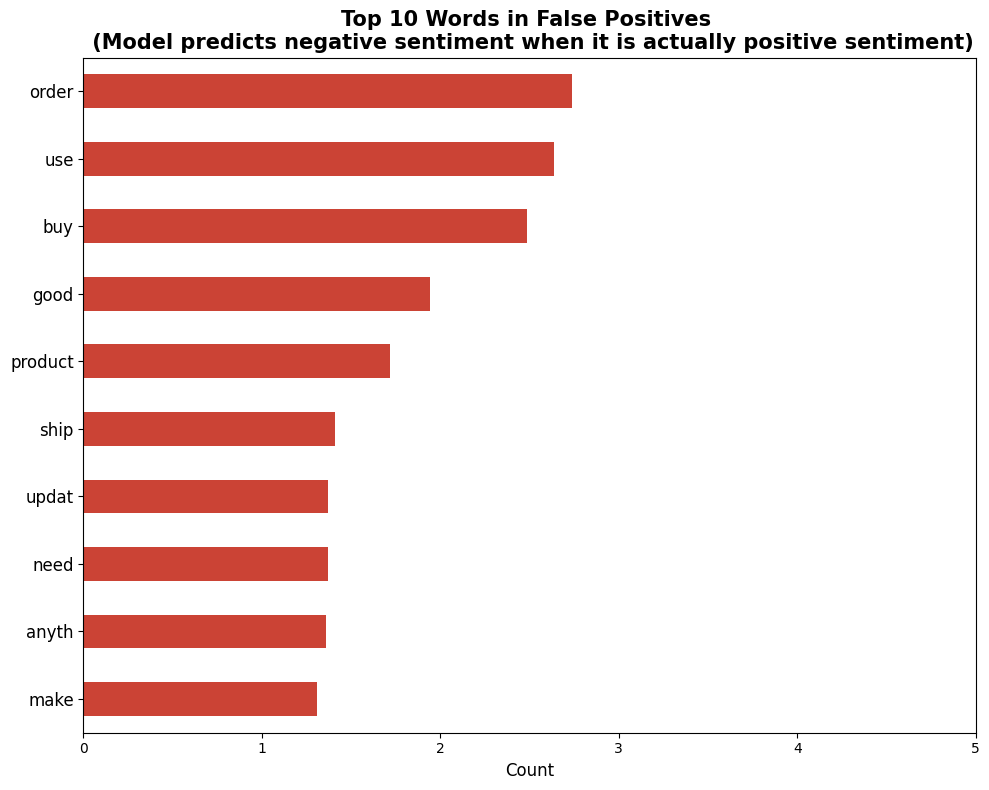

In [116]:
# Top words seen in False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
barplot_tvec(df=test,
             pred=1, 
             title="Top 10 Words in False Positives \n (Model predicts negative sentiment when it is actually positive sentiment)", 
             color='#CB4335')

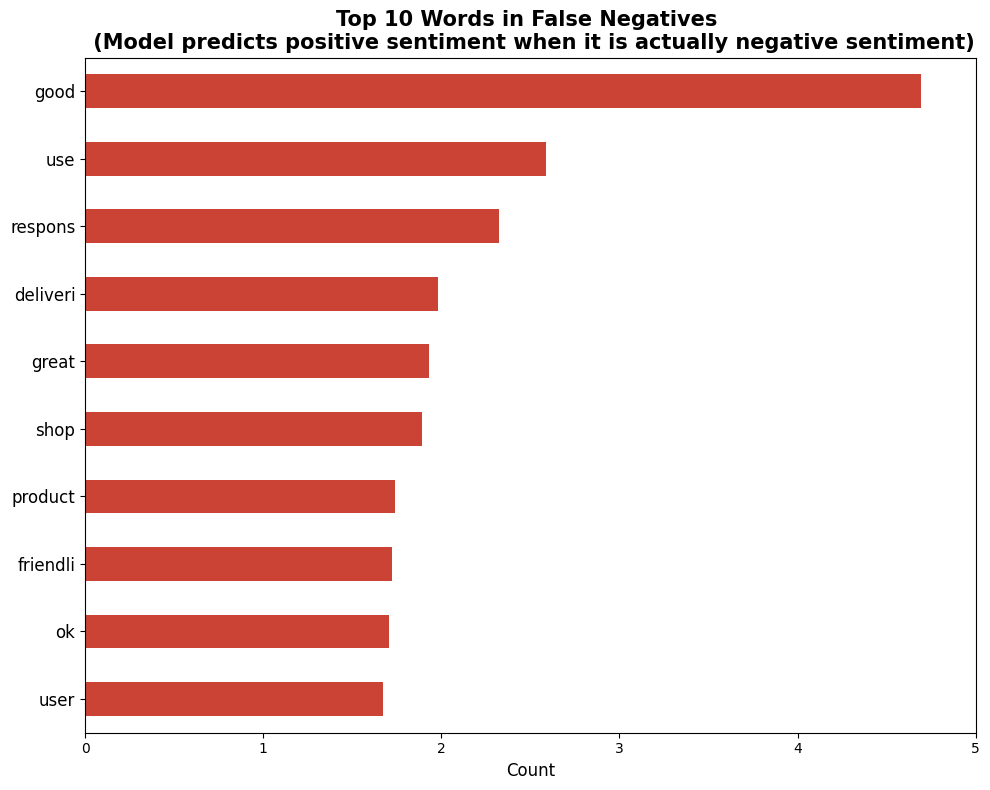

In [117]:
# Top words seen in False Negatives - Model incorrectly predicts these as postive sentiment when they are actually negative sentiment
barplot_tvec(df=test,
             pred=0, 
             title="Top 10 Words in False Negatives \n (Model predicts positive sentiment when it is actually negative sentiment)", 
             color='#CB4335')

In [118]:
# False Negatives
fn = test[(test['correctly_classified']==0) & (test['pred']==0)][['content','content_stem','score']]

In [119]:
# Count the number of times the word 'good' appears in the review
fn['count_good'] = fn['content_stem'].str.count('good')

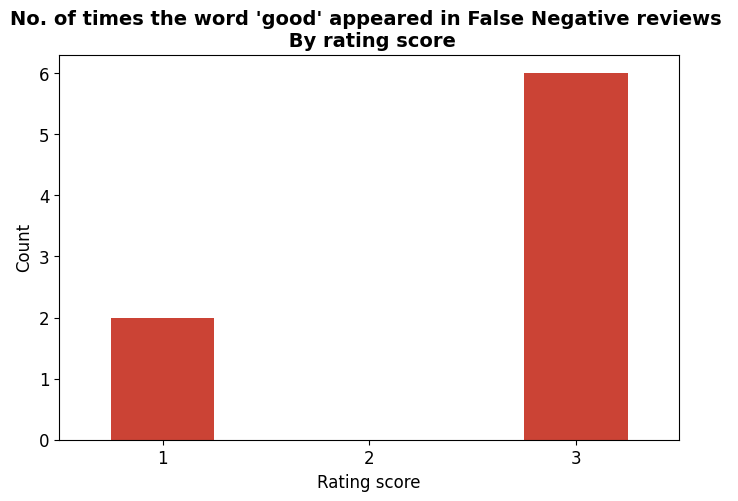

In [120]:
plt.figure(figsize=(8,5))

# Group False Negative reviews by their ratings and sum up the no. of times the word 'good' was seen
fn.groupby('score')['count_good'].sum().plot(kind='bar', color='#CB4335')

plt.title("No. of times the word 'good' appeared in False Negative reviews \n By rating score", size=14, weight='bold')
plt.ylabel("Count", size=12)
plt.yticks(size=12)
plt.xlabel("Rating score", size=12)
plt.xticks(size=12, rotation=0);

In [121]:
# View only the False Negatives that has the words 'good' in it
fn[fn['count_good']>0][['content','content_stem','score']].sort_values(by='score')

,content,content_stem,score
462,Not good,good,1
485,No good apps,good app,1
321,Good app with reasonable price,good reason price,3
343,Good,good,3
362,"Good platform for products and purchases but the app lags and hangs very often. Hopefully the app can be more stable so that consumers can have a better experience shopping. Thank you. Edit: Hi, these 2 days, the app hangs badly, making hard for any purchases or browsing to take place. Kindly assist to look into the issue. Thank u",good platform product purchas lag hang often hope stabl consum better experi shop thank edit hi day hang badli make hard purchas brows take place kindli assist look issu thank u,3
389,1. it has become laggy. 2. they should screen their sellers to protect buyers. Some buyers are real scammers. 3. this app is still more user friendly than q10 and ezbuy 4. should give better vouchers q10 has better vouchers. 5. the coins are very little compared to q10. 6. some times it is difficult to find a product as they do not have picture recognition 7. the pricing of goods from the same sellers on q10 are more expensive in shopee 8. flash sale needs improvement,becom laggi screen protect buyer buyer real scammer still user friendli q ezbuy give better voucher q better voucher coin littl compar q time difficult find product pictur recognit price good q expens flash sale need improv,3
502,"Price is good, but not everything can be find in there.",price good everyth find,3
636,Good,good,3


Misclassification in the context of 'good' occurs when:
- User leaves a positive review but gives rates the app 3-stars. For example, "good app with reasonable price". These kinds of misclassifications are unavoidable and even a human will interpret it to be positive sentiment.
- User writes a review that mentions Shopee is 'good' in a one aspect, but indicates that there are other areas of improvement. Misclassifications of this sort can be reduced if the model was trained on more negative sentiment. Given the limited pool of negative reviews on Google Play, we can look into training the model on negative reviews from the Apple App Store in the future. 
- Given that we have removed stopwords like 'not' and 'no' during pre-processing, the word 'good' rather than 'not good' will be fed into the model. As these reviews typically contain very few words and do not provide feedback on how Shopee can improve the app experience, there are no dire consequences to such misclassifications.

## Topic Modeling for Negative Sentiment

Next, we will use Gensim's LDA to identify the key pain points that dissatisfied customers are facing. 

Before running LDA, we will first perform a simple pre-processing by removing stopwords, lemmatizing and using SpaCy to only keep tokens that are nouns, adjectives, verbs or adverbs. This approach gave us more distinct topics than if we were to just rely on the same pre-processing approach as that used during classification modeling.

In [122]:
# Create a list of all the textual data from negative reviews
data = reviews[reviews['target']==1]['content'].values.tolist()

In [123]:
# Assign NLTK's stopwords to stop_words
stop_words = stopwords.words('english')

# Include frequently occuring words like 'app' and 'shopee' to the stopwords list. These words will not value add to our topics.
stop_words.extend(['app','shopee','shoppee','shoppe'])

In [133]:
# !python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.3/12.8 MB 10.6 MB/s eta 0:00:02
     -- ------------------------------------- 0.7/12.8 MB 9.1 MB/s eta 0:00:02
     --- ------------------------------------ 1.2/12.8 MB 9.6 MB/s eta 0:00:02
     ----- ---------------------------------- 1.6/12.8 MB 9.5 MB/s eta 0:00:02
     ------ --------------------------------- 2.1/12.8 MB 9.0 MB/s eta 0:00:02
     ------- -------------------------------- 2.5/12.8 MB 9.5 MB/s eta 0:00:02
     --------- ------------------------------ 3.0/12.8 MB 9.5 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.8 MB 9.4 MB/s eta 0:00:01
     ----------- ---------------------------- 3.6/12.8 MB 8.6 MB/s eta 0:00:02
     ------------ --------------------------- 4.1/12.8 MB 9.0 MB/s eta 0:00:01
     -------------- ------------------------- 4.6/12.8 MB 9.2 MB/s eta 0:00:01
     --------------- ------------------------ 5.0/12.8 MB 

In [134]:
# Remove stopwords, lemmatize and only keep tokens that fall into these part of speech tags
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):

    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        # Lemmatize and only keep tokens that have certain part of speech tags
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags]) 
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# Pre-processing text
data_ready = process_words(data)

In [135]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready) 

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, # Number of topics
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.021*"product" + 0.021*"good" + 0.019*"change" + 0.018*"user" + '
  '0.017*"money" + 0.017*"experience" + 0.016*"even" + 0.014*"bad" + '
  '0.014*"seller" + 0.012*"team"'),
 (1,
  '0.028*"payment" + 0.025*"keep" + 0.022*"use" + 0.019*"account" + '
  '0.016*"even" + 0.016*"time" + 0.016*"try" + 0.015*"page" + 0.015*"work" + '
  '0.015*"update"'),
 (2,
  '0.038*"item" + 0.035*"seller" + 0.028*"order" + 0.023*"customer" + '
  '0.018*"get" + 0.017*"receive" + 0.017*"send" + 0.015*"refund" + '
  '0.014*"service" + 0.014*"support"')]


In [138]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Formatting the table
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

C:\Users\steam\AppData\Local\Temp\ipykernel_21824\4234828165.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\steam\AppData\Local\Temp\ipykernel_21824\4234828165.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\steam\AppData\Local\Temp\ipykernel_21824\4234828165.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\steam\AppD

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.7154,"item, seller, order, customer, get, receive, send, refund, service, support","[sake, yr, welcome, gift, state, clearly, order, item, get, free, welcome, gift, feel, bad, try, select, free, gift, keep, get, error, speak, tell, get, free, gift, first, make, purchase, good, job, go, use, get, order]"
1,1,0,0.5473,"product, good, change, user, money, experience, even, bad, seller, team","[wild, variety, product, however, buy, certain, stuff, prefer, stuff, come, long, warranty, usually, clothing, prefer, brick, motar, see, fit, long, physical, product, gladly, purchase, good, include, warranty, go, quality, handy, know, save, money, purchase, really, good, stuff, keep, come, back, good, place, bargain]"
2,2,1,0.7002,"payment, keep, use, account, even, time, try, page, work, update","[terrible, payment, long, time, use, credit, debit, payment, glitch, today, keep, deny, payment, error, message, oop, payment, fail, step, give, help, desk, still, go, annoying, face, issue, note, add, payment, method, paypal, instead, ibg]"
3,3,2,0.7888,"item, seller, order, customer, get, receive, send, refund, service, support","[use, good, problem, order, buy, stuff, recently, platform, suck, allow, seller, cancel, order, auto, cancellation, system, keep, drag, cancellation, date, ask, customer, service, personnel, help, suggest, ask, wait, auto, cancellation, occur, uninstall, receive, refund, edit, send, feedback, reply, ask, wait, auto, cancellation, date, occur, ask, send, anymore, feedback, really, edit, finally, transaction, cancel, sending, email, ask, solution, bring, issue, doubt, asking, wait, yet, receive, email, message, state, receive, refund]"
4,4,1,0.5909,"payment, keep, use, account, even, time, try, page, work, update","[lousy, service, suddenly, prompt, pay, use, pay, additional, coin, earn, top, pin, page, drag, day, troubleshoot, end, coin, credit, lose, cashback, expire, email, reply, pertain, query, advise, cashback, applicable, successful, order, go, delete, soon]"


In [142]:
# Keywords of each dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') 

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show the 3 topics
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9503,"product, good, change, user, money, experience, even, bad, seller, team","[describe, rather, company, disappoint, know, many, scheme, seller, sell, counterfeit, product, fact, allow, transaction, reflect, social, corporate, consumer, buyer, section, trade, mark, act, criminal, offence, sell, counterfeit, good, include, resell, product, online, platform, expect]"
1,1,0.9693,"payment, keep, use, account, even, time, try, page, work, update","[late, update, system, error, message, keep, popping, make, payment, use, certain, credit, card, discount, voucher, apply, access, account, setting, amendment, fix, issue]"
2,2,0.9631,"item, seller, order, customer, get, receive, send, refund, service, support","[first, purchase, great, make, enquiry, seller, musical, instrumental, shop, interested, reply, never, come, back, nearly, week, still, wait, today, responsive, great, dissapointment, item, cost]"


d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will b

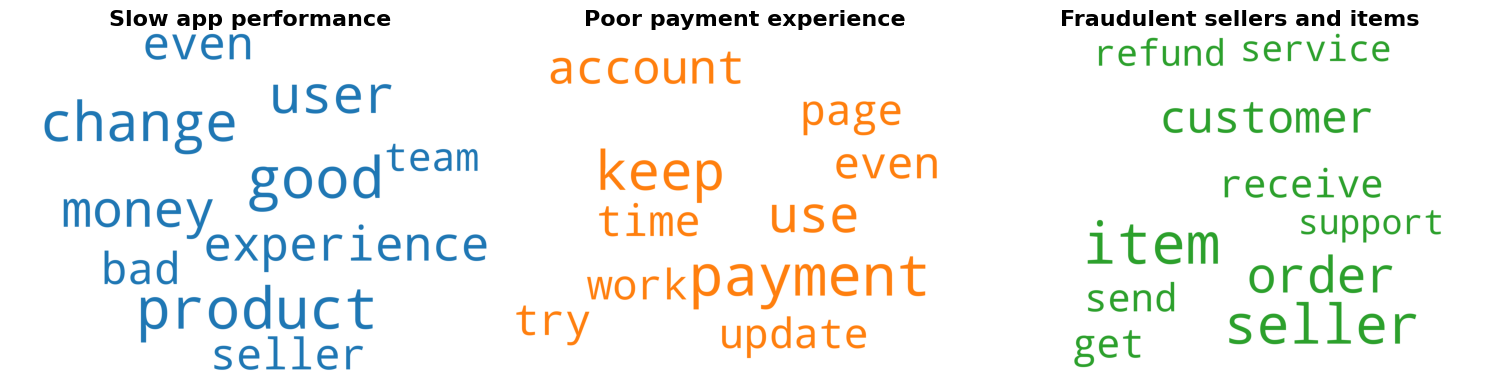

In [143]:
# Wordcloud of Top 10 words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15,10), sharex=True, sharey=True)

topic_names = ['Slow app performance', 'Poor payment experience', 'Fraudulent sellers and items']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], weight='bold', fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [144]:
# Visualisation of the topics estimated using LDA
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

d:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.118882  0.214179       1        1  39.551131
1     -0.263957 -0.013715       2        1  36.663458
0      0.145075 -0.200464       3        1  23.785410, topic_info=           Term        Freq       Total Category  logprob  loglift
10         item  289.000000  289.000000  Default  30.0000  30.0000
14        order  214.000000  214.000000  Default  29.0000  29.0000
72      payment  197.000000  197.000000  Default  28.0000  28.0000
12         keep  174.000000  174.000000  Default  27.0000  27.0000
87     customer  170.000000  170.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
103      seller   62.263020  322.061012   Topic3  -4.2851  -0.2073
387        well   32.280436   56.960767   Topic3  -4.9420   0.8682
427  disappoint   27.359416   35.045689   Topic3  -5.1074   1.1885
510        many   29.305415   55.463649   Topic3  -5.0387   0.7981
13         make   29.432915   92.963007   Topic3  -5.0344   0.2860

[155 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
158       2  0.992941   account
684       3  0.992129        ad
159       1  0.991730      also
138       2  0.987517    always
55        3  0.986155  annoying
...     ...       ...       ...
387       1  0.210671      well
387       2  0.210671      well
387       3  0.561790      well
472       2  0.988665      work
696       1  0.993004     wrong

[164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

We can conclude that the 3 topics are rather distinct as the bubbles are far away from one another on the intertopic distance map. The bar chart on the right represents the individual terms that are the most useful for interpreting a selected topic.   

We will be browsing through some of the negative reviews in our dataset to better contextualise the 3 pain points that the LDA model has identified.

In [145]:
# Browse through the reviews that contain the top words related to each topic
reviews[(reviews['target']==1) & (reviews['content'].str.contains('payment'))]['content']

7                                 Terrible payment. For a long time I have been using credit/debit payment without any glitch. Today, I kept being denied of my payment. Error message: Oops payment failed. Did all the steps given by the help desk but still no go. Very annoying to face this issue. On another note, why can't you add more payment methods like PayPal instead of just IBG?
18                                                                                                                                                                                                                                                                         Great app, but i cannot checkout my items and its very frustrating. When i reach the payment page, it doesn't load....
51                                                                                                                                                                                                                                  

## Pain Points and Recommendations

**Poor payment experience** 

Customers are most frustrated when they run into payment issues during checkout. The payment was either denied or the payment page simply took too long to load. Although customers are given the option of paying via bank transfers, the process is not entirely seamless. Some were not able to upload the receipt for verification due to a platform error. A handful of customers have also mentioned in their Google Play reviews that they were not able to apply their voucher or discount codes at the point of checkout. We can imagine the disappointment that customers face when they were not able to enjoy the promotional prices that were promised.

Consumers today demand a fast, convenient and secure payment experience. As such, the software engineers at Shopee will need to look into enhancing the stability and reliability of its payment gateway service. Given that card payments are processed through third-party providers, engineers will need to figure out if these payment issues are surfacing from the third-party providers' end, or as a result of Shopee's internal systems. Reducing friction in the payment process will definitely help to reduce cart abandonment.

**Fraudulent sellers and items**  

Several customers have reported fraudulent seller behaviour. These scams include not having received the items ordered, or receiving counterfeit, defective products. When these issues were raised to Shopee's customer service, the problem was either not resolved in a timely fashion, or customers did not receive their refunds. This has thus disappointed and angered many affected customers and several feel that Shopee favours the sellers over the buyers.   

Building a robust model that identifies and blocks fraudulent sellers at the early stages will help to prevent seller fraud and preserve buyers' trust. This involves tracking a range of behavioural pattern among sellers and combing through their digital identity for any signs of suspicious behaviour. While the team continues to build better fraud detection algorithms, it will not be possible to completely stamp out frauds. Shopee could improve its buyers' protection scheme to boost buyers' confidence. Given Shopee's escrow service, in the event when the order is not delivered or the items do not match the seller's description, Shopee should reimburse the full cost to the customer.

**Slow app performance**

Users have reported that the app hangs or crashes at the login and payment page. This is an issue of latency, meaning that there is a delay between an action and a response. Several other reviews have also mentioned that the app's functionalities had slowed down considerably after updating the app. Some were reportedly not able to load Shopee's games after updating the app, and were thus upset that they could not collect Shopee coins. These coins can be used to offset the cost of the next purchase.

Developers will need to optimise Shopee's traffic scheduling platform's throughput and latency. Ensuring smooth running of the platform is crucial especially during big sale events where the server runs the risk of being overloaded due to high traffic. Developers will also need to stress test before releasing new app updates to ensure that the app's performance is not compromised.

## Conclusion

The production model is a Voting Classifier consisting of an ensemble of a Logistic Regression and SVC. Given its relatively high accuracy (0.892) and recall (0.87) on the test set, we can conclude that the model generalises well on unseen data. This model serves as a good start for Shopee's product managers to classify sentiments and understand customers' pain points through Google Play reviews.

The data science team has also identified 3 pain points among dissatisfied customers through topic modeling. Product managers will need to work closely with software engineers and developers to build a seamless payments experience, crack down on fraudulent sellers and improve app performance in terms of latency.
 
Despite the model's relatively high performance, there is still room for improvement. Misclassifications tend to occur when users leave mixed reviews on Shopee. For instance, when the user praises Shopee for being 'good' in one aspect, but indicates that there are other areas of improvement, the model classifies this is a positive review. Sentiments are inherently subjective. However, given that the user is dissatisfied with certain aspects of the shopping experience, it is worth classifying such reviews as negative sentiments. This will allow product managers to be informed of these pain points. In order to reduce misclassifications, we can train the model on reviews from the Apple App Store too. Given that we have also identified customers' pain points, the next step would be to use these topics as features in our sentiment classification model. This may help to improve the model's accuracy and recall.